In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **SetPath**

In [140]:
DATA_PATH = '/home/athimet/FRA532_Exam/src/pmzbbot_sensors/calibration/'

EXPR_NUM = 1

# **ReadCsvtoDF**

In [141]:
def read_data(data_path, expr_num, rpm, id_num, base_df):

    dpath = data_path + 'Experiment_' + str(expr_num) + '_' + str(rpm) + '_id_' + str(id_num) + '.csv'
    df = pd.read_csv(dpath)
    # Add the experiment rpm to the dataframe
    df['rpm'] = rpm
    # Concatenate the dataframes
    if base_df.empty:
        base_df = df
    else:
        base_df = pd.concat([base_df, df], ignore_index=True)

    return base_df

# **Plot DF**

In [142]:
def plot_experimet_data(df):
    #Plot df Data
    time = df['time']
    right_wheel = df['left_wheel_vel']
    left_wheel = df['right_wheel_vel']
    tar_rpm = df['rpm'][0]

    # Convert to np array
    time = np.array(time)
    right_wheel = np.array(right_wheel)
    left_wheel = np.array(left_wheel)

    # Calculate Mean
    mean_right_wheel = np.mean(right_wheel)
    mean_left_wheel = np.mean(left_wheel)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(time, right_wheel, label='Right Wheel')
    ax.plot(time, left_wheel, label='Left Wheel')
    ax.axhline(mean_right_wheel, color='r', linestyle='--', label='Mean Right Wheel')
    ax.axhline(mean_left_wheel, color='g', linestyle='--', label='Mean Left Wheel')
    ax.axhline(tar_rpm, color='b', linestyle='--', label='Target RPM')
    ax.legend()
    plt.yticks(np.arange(tar_rpm-5,tar_rpm+5,1))
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (rpm)')
    plt.title(f'Target RPM: {tar_rpm}, Right Wheel Mean: {mean_right_wheel:.2f}, Left Wheel Mean: {mean_left_wheel:.2f}')

    print(f'Right Wheel difference from target: {mean_right_wheel - tar_rpm:.2f}')
    print(f'Left Wheel difference from target: {mean_left_wheel - tar_rpm:.2f}')

## **Example Reading**

Right Wheel difference from target: 0.03
Left Wheel difference from target: 0.13


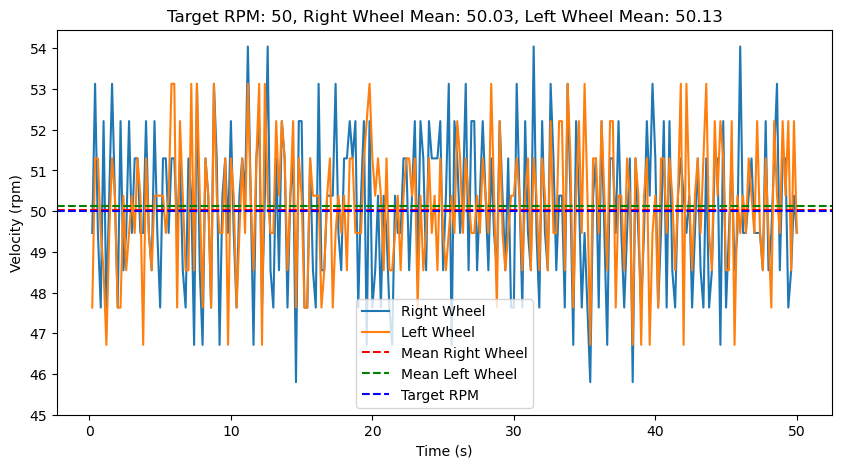

In [171]:
sample_df = pd.DataFrame(columns=['time', 'left_wheel_vel', 'left_wheel_vel', 'rpm'])
sample_df = read_data(DATA_PATH, EXPR_NUM, rpm=50, id_num=703, base_df=sample_df)
plot_experimet_data(sample_df)
# sample_df

# **LR Model**

In [144]:
# Fine Linear Regression

from sklearn.linear_model import LinearRegression

In [145]:
def GetLR_Coef(df, zone_start, zone_end):

    # Create the model for the right wheel
    model_right = LinearRegression()
    X = df['rpm'].values.reshape(-1, 1)
    y = df['right_wheel_vel']

    model_right.fit(X, y)

    # Get the model parameters
    right_slope = model_right.coef_
    right_intercept = model_right.intercept_

    # Create the model for the left wheel
    model_left = LinearRegression()
    X = df['rpm'].values.reshape(-1, 1)
    y = df['left_wheel_vel']

    model_left.fit(X, y)

    # Get the model parameters
    left_slope = model_left.coef_
    left_intercept = model_left.intercept_

    getpredrpm = lambda x, m, b: m*x + b
    invgetpredrpm = lambda y, m, b: (y - b)/m

    grid_size = 0.5
    # Plot the linear regression
    fig, ax = plt.subplots()
    ax.scatter(df['rpm'], df['right_wheel_vel'], label='Right Wheel')
    ax.scatter(df['rpm'], df['left_wheel_vel'], label='Left Wheel')
    # Plot the linear regression
    x = np.arange(zone_start, zone_end+grid_size, grid_size)
    # Plot the linear regression
    y = getpredrpm(x, right_slope, right_intercept)
    ax.plot(x, y, label='Right Wheel Linear Regression', color='r')
    y = getpredrpm(x, left_slope, left_intercept)
    ax.plot(x, y, label='Left Wheel Linear Regression', color='g')
    # Plot ideal line
    ax.plot(x, x, label='Ideal Line', color='b', linestyle='--')
    # Add grid
    ax.grid(True)
    ax.legend()
    plt.xticks(np.arange(zone_start,zone_end+2,2))
    plt.yticks(np.arange(zone_start-10,zone_end+10-2,2))
    plt.xlabel('LR Input RPM')
    plt.ylabel('LR Predicted RPM')
    plt.title('Linear Regression for Zone ' + str(zone_start) + ' to ' + str(zone_end))
    plt.show()

    print(f'Left Wheel: Slope = {left_slope[0]}, Intercept = {left_intercept}')
    
    print(f'Right Wheel: Slope = {right_slope[0]}, Intercept = {right_intercept}')

    return right_slope, right_intercept, left_slope, left_intercept

## **Zone of LinearRegression**

In [146]:
zone_1_start = 10
zone_1_end = 40

zone_2_start = 40
zone_2_end = 70

step = 10

### **Zone1**

In [147]:
df_exp_z1 = pd.DataFrame(columns=['time', 'right_wheel_vel', 'left_wheel_vel', 'rpm'])

for rpm in range(zone_1_start, zone_1_end+step, step):
    print(f'Processing RPM: {rpm}')
    for id_num in range(1, 3):
        print(f'Processing ID: {id_num}')
        df_exp_z1 = read_data(DATA_PATH, EXPR_NUM, rpm, id_num, df_exp_z1)

df_exp_z1

# Mean of the data
left_mean = df_exp_z1['left_wheel_vel'].mean()
right_mean = df_exp_z1['right_wheel_vel'].mean()
print(f'Left Wheel Mean: {left_mean:.6f}, Right Wheel Mean: {right_mean:.6f}')

Processing RPM: 10
Processing ID: 1
Processing ID: 2
Processing RPM: 20
Processing ID: 1
Processing ID: 2
Processing RPM: 30
Processing ID: 1
Processing ID: 2
Processing RPM: 40
Processing ID: 1
Processing ID: 2
Left Wheel Mean: 24.949550, Right Wheel Mean: 24.958710


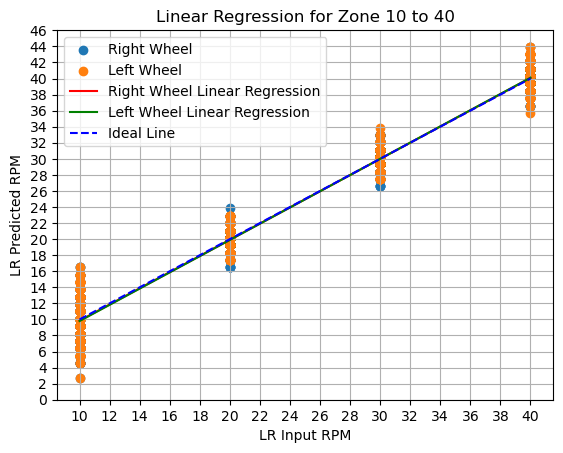

Left Wheel: Slope = 1.010073223731285, Intercept = -0.302280309691227
Right Wheel: Slope = 1.0075084252814017, Intercept = -0.22900038146364565


In [148]:
z1_right_slope, z1_right_intercept, z1_left_slope, z1_left_intercept = GetLR_Coef(df_exp_z1, zone_1_start, zone_1_end)

### **Zone2**

In [149]:
df_exp_z2 = pd.DataFrame(columns=['time', 'right_wheel_vel', 'left_wheel_vel', 'rpm'])

for rpm in range(zone_2_start, zone_2_end+step, step):
    print(f'Processing RPM: {rpm}')
    for id_num in range(1, 3):
        print(f'Processing ID: {id_num}')
        df_exp_z2 = read_data(DATA_PATH, EXPR_NUM, rpm, id_num, df_exp_z2)

df_exp_z2

Processing RPM: 40
Processing ID: 1
Processing ID: 2
Processing RPM: 50
Processing ID: 1
Processing ID: 2
Processing RPM: 60
Processing ID: 1
Processing ID: 2
Processing RPM: 70
Processing ID: 1
Processing ID: 2


,time,left_wheel_vel,right_wheel_vel,rpm
0,0.199763,40.303999,39.388003,40
1,0.399811,41.220000,38.472001,40
2,0.599977,40.303999,42.136002,40
3,0.800026,40.303999,39.388003,40
4,0.999741,40.303999,39.388003,40
...,...,...,...,...
1995,49.199465,73.279998,70.531999,70
1996,49.399424,70.531999,68.699996,70
1997,49.599401,70.531999,68.699996,70
1998,49.799386,69.615997,69.615997,70


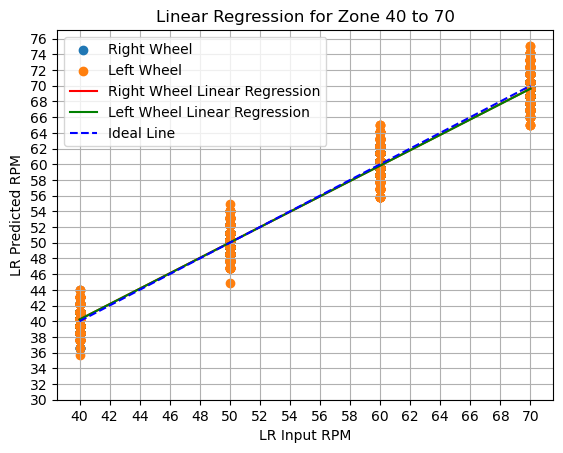

Left Wheel: Slope = 0.9799550216518994, Intercept = 1.0235435573910365
Right Wheel: Slope = 0.9807244537089485, Intercept = 0.9894689225123656


In [150]:
z2_right_slope, z2_right_intercept, z2_left_slope, z2_left_intercept = GetLR_Coef(df_exp_z2, zone_2_start, zone_2_end)